## Long Puts OTM Strategy Eval

Buy stock at the close and hold until the open. Hypothesis is that traders are unwilling to hold overnight?

Evaluation steps:

1. Pull stocks from Xano
2. Get historical prices on each stock
3. Calculate the change from the previous close

In [24]:
%matplotlib inline

import requests
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

In [2]:
url = 'https://iocalc.com/api:gPr_YnZX/getstocks'

response = requests.get(url)

stock_table = pd.json_normalize(response.json()['stocks'])
stock_table

,id,created_at,name,symbol,price,target,marketcap,week52high,week52low,dividendyield,day200movingavg,day50movingavg,exdividend,nextearnings,eps,pe,beta,change_1yr,change_ytd,pricetargethigh,pricetargetlow,symboltype,analysts,currency,totaltracking
0,20,1669700842304,Meta Financial Group Inc.,CASH,43.05,72.50,1741265522,65.9,36.02,0.003454,55.53,59.15,2021-12-08,2022-01-26,8.76,6.2630944593554,1.1439973981583,0.48746215755319,-0.030673818303721,79.0,70.0,stock,4,USD,0
1,19,1669700858682,Global X Funds,QYLD,16.32,0.00,5871377700,22.43,19.11,0.121877,21.72,21.91,2022-01-24,None,,,,-0.0083631439208244,-0.079315006759802,0.0,0.0,,0,,0
2,11,1669700953278,Verizon Communications Inc,VZ,38.24,60.00,223153658344,58.44,49.09,0.058884,52.74,52.07,2022-01-07,2022-01-25,5.32,10.124939126336,0,-0.032254541085492,0.035421706459115,71.0,52.0,stock,26,USD,0
3,49,1669701204278,"Delta Air Lines, Inc.",DAL,33.87,51.56,24262923840,52.28,33.4,0.000000,40.26,38.95,None,2022-04-14,-0.1064,-356.807703535,1.1989249496749,-0.05225,-0.029938587512794,67.0,40.0,stock,18,USD,0
4,54,1669702417097,Humana Inc.,HUM,534.29,485.87,48727349718,473.14,351.2,0.007368,427.87,430.11,2021-12-30,2022-02-02,20.51,18.229461173999,0.54182997393569,-0.058274921620204,-0.18272754710473,581.0,410.0,stock,23,USD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,74,1643141926509,"Oceaneering International, Inc.",OII,13.88,17.72,1282413359,18.2,8.27,0.000000,12.87,12.16,None,2022-02-24,-0.3555,-36.130426529836,1.8863947677163,0.21916508538899,0.13616268788683,20.0,16.0,stock,9,USD,0
66,70,1669700854196,Kosmos Energy Ltd,KOS,6.19,5.96,1916009623,4.89,1.8,0.000000,3.15,3.92,None,2022-02-24,-0.4139,-11.364502259128,2.3177199524754,0.58208955223881,0.22543352601156,8.0,4.1,stock,7,USD,0
67,76,1669701715934,GlobalFoundries Inc,GFS,63.90,79.10,33128671394,79.49,43.59,0.000000,60.30,62.39,None,2022-04-27,-0.4949,-132.34898464626,0,0.34245689655172,-0.041249807603509,100.0,46.0,stock,15,USD,0
68,65,1643141629684,ALPS Fund Services,SBIO,33.95,0.00,146072500,64.04,31.96,0.000000,44.26,40.35,2021-12-22,None,,,,-0.38581129378127,-0.18631628787879,0.0,0.0,,0,,0


In [34]:
config = pd.read_csv('../tradier_exploration/sandbox.config')
token = config.prod_token[0]

In [35]:
endpoint = 'https://api.tradier.com'
path = '/v1/markets/history'

all_stock_history = pd.DataFrame()

for symbol in stock_table['symbol']:
    response = requests.get(f'{endpoint}{path}',
        params={'symbol':f'{symbol}', 
                'interval': 'daily', 
                'start': '2000-01-01', 
                'end': f'{datetime.today().date().isoformat()}'},
        headers={'Authorization': f'Bearer {token}', 
                 'Accept': 'application/json'}
    )
    json_response = response.json()
    this_stock = pd.json_normalize(json_response['history']['day'])
    this_stock['symbol'] = symbol
    
    all_stock_history = pd.concat([all_stock_history, this_stock], axis = 0, ignore_index = True)

In [36]:
all_stock_history['yest_close'] = all_stock_history.groupby(['symbol'])['close'].shift(1)
all_stock_history

,date,open,high,low,close,volume,symbol,yest_close
0,2000-01-03,4.166667,4.166667,4.0,4.000000,5700,CASH,NaN
1,2000-01-04,3.958333,3.958333,3.833333,3.833333,21900,CASH,4.000000
2,2000-01-05,3.770833,3.770833,3.770833,3.770833,2700,CASH,3.833333
3,2000-01-06,3.916667,4.0,3.833333,3.916667,3300,CASH,3.770833
4,2000-01-07,3.833333,3.833333,3.75,3.750000,27300,CASH,3.916667
...,...,...,...,...,...,...,...,...
256863,2022-11-22,4.32,4.41,4.2,4.360000,2867496,RKLB,4.320000
256864,2022-11-23,4.36,4.445,4.32,4.400000,3245839,RKLB,4.360000
256865,2022-11-25,4.5,4.5525,4.14,4.180000,3209948,RKLB,4.400000
256866,2022-11-28,4.17,4.2885,4.0,4.010000,3845317,RKLB,4.180000


In [37]:
all_stock_history.dtypes

date           object
open           object
high           object
low            object
close         float64
volume          int64
symbol         object
yest_close    float64
dtype: object

In [38]:
all_stock_history['open'] = all_stock_history['open'].astype(np.float64)
all_stock_history['overnight_return'] = all_stock_history['open'] - all_stock_history['yest_close']
all_stock_history['overnight_return_perc'] = (all_stock_history['open'] - all_stock_history['yest_close']) / all_stock_history['yest_close']
all_stock_history

,date,open,high,low,close,volume,symbol,yest_close,overnight_return,overnight_return_perc
0,2000-01-03,4.166667,4.166667,4.0,4.000000,5700,CASH,NaN,NaN,NaN
1,2000-01-04,3.958333,3.958333,3.833333,3.833333,21900,CASH,4.000000,-0.041667,-0.010417
2,2000-01-05,3.770833,3.770833,3.770833,3.770833,2700,CASH,3.833333,-0.062500,-0.016304
3,2000-01-06,3.916667,4.0,3.833333,3.916667,3300,CASH,3.770833,0.145834,0.038674
4,2000-01-07,3.833333,3.833333,3.75,3.750000,27300,CASH,3.916667,-0.083334,-0.021277
...,...,...,...,...,...,...,...,...,...,...
256863,2022-11-22,4.320000,4.41,4.2,4.360000,2867496,RKLB,4.320000,0.000000,0.000000
256864,2022-11-23,4.360000,4.445,4.32,4.400000,3245839,RKLB,4.360000,0.000000,0.000000
256865,2022-11-25,4.500000,4.5525,4.14,4.180000,3209948,RKLB,4.400000,0.100000,0.022727
256866,2022-11-28,4.170000,4.2885,4.0,4.010000,3845317,RKLB,4.180000,-0.010000,-0.002392


In [42]:
all_stock_history['rolling_30day_sum'] = (
    all_stock_history.groupby('symbol')['overnight_return']
        .rolling(30, min_periods = 1).sum().reset_index(0, drop = True))

In [43]:
all_stock_history

,date,open,high,low,close,volume,symbol,yest_close,overnight_return,overnight_return_perc,rolling_30day_sum
0,2000-01-03,4.166667,4.166667,4.0,4.000000,5700,CASH,NaN,NaN,NaN,NaN
1,2000-01-04,3.958333,3.958333,3.833333,3.833333,21900,CASH,4.000000,-0.041667,-0.010417,-0.041667
2,2000-01-05,3.770833,3.770833,3.770833,3.770833,2700,CASH,3.833333,-0.062500,-0.016304,-0.104167
3,2000-01-06,3.916667,4.0,3.833333,3.916667,3300,CASH,3.770833,0.145834,0.038674,0.041667
4,2000-01-07,3.833333,3.833333,3.75,3.750000,27300,CASH,3.916667,-0.083334,-0.021277,-0.041667
...,...,...,...,...,...,...,...,...,...,...,...
256863,2022-11-22,4.320000,4.41,4.2,4.360000,2867496,RKLB,4.320000,0.000000,0.000000,1.145000
256864,2022-11-23,4.360000,4.445,4.32,4.400000,3245839,RKLB,4.360000,0.000000,0.000000,1.195000
256865,2022-11-25,4.500000,4.5525,4.14,4.180000,3209948,RKLB,4.400000,0.100000,0.022727,1.445000
256866,2022-11-28,4.170000,4.2885,4.0,4.010000,3845317,RKLB,4.180000,-0.010000,-0.002392,1.345000


In [44]:
all_stock_history

,date,open,high,low,close,volume,symbol,yest_close,overnight_return,overnight_return_perc,rolling_30day_sum
0,2000-01-03,4.166667,4.166667,4.0,4.000000,5700,CASH,NaN,NaN,NaN,NaN
1,2000-01-04,3.958333,3.958333,3.833333,3.833333,21900,CASH,4.000000,-0.041667,-0.010417,-0.041667
2,2000-01-05,3.770833,3.770833,3.770833,3.770833,2700,CASH,3.833333,-0.062500,-0.016304,-0.104167
3,2000-01-06,3.916667,4.0,3.833333,3.916667,3300,CASH,3.770833,0.145834,0.038674,0.041667
4,2000-01-07,3.833333,3.833333,3.75,3.750000,27300,CASH,3.916667,-0.083334,-0.021277,-0.041667
...,...,...,...,...,...,...,...,...,...,...,...
256863,2022-11-22,4.320000,4.41,4.2,4.360000,2867496,RKLB,4.320000,0.000000,0.000000,1.145000
256864,2022-11-23,4.360000,4.445,4.32,4.400000,3245839,RKLB,4.360000,0.000000,0.000000,1.195000
256865,2022-11-25,4.500000,4.5525,4.14,4.180000,3209948,RKLB,4.400000,0.100000,0.022727,1.445000
256866,2022-11-28,4.170000,4.2885,4.0,4.010000,3845317,RKLB,4.180000,-0.010000,-0.002392,1.345000


In [46]:
plot_data = all_stock_history.loc[all_stock_history['date'] >= '2022-01-01']

symbol
ALGN    AxesSubplot(0.125,0.11;0.775x0.77)
ALK     AxesSubplot(0.125,0.11;0.775x0.77)
AMD     AxesSubplot(0.125,0.11;0.775x0.77)
BBWI    AxesSubplot(0.125,0.11;0.775x0.77)
BIO     AxesSubplot(0.125,0.11;0.775x0.77)
                       ...                
UTHR    AxesSubplot(0.125,0.11;0.775x0.77)
VLO     AxesSubplot(0.125,0.11;0.775x0.77)
VSAT    AxesSubplot(0.125,0.11;0.775x0.77)
VZ      AxesSubplot(0.125,0.11;0.775x0.77)
XOM     AxesSubplot(0.125,0.11;0.775x0.77)
Name: rolling_30day_sum, Length: 70, dtype: object

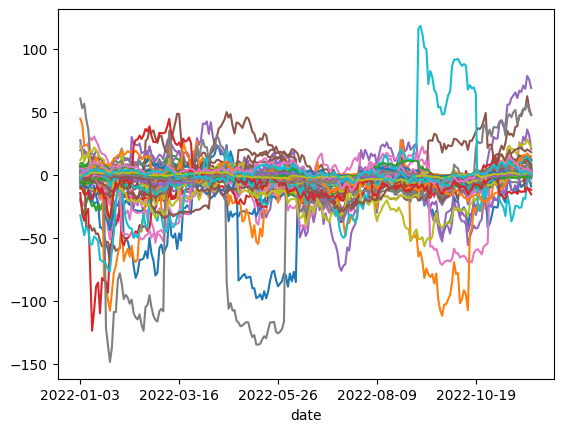

In [48]:
plot_data.set_index('date', inplace = True)
plot_data.groupby('symbol')['rolling_30day_sum'].plot()